In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC

# Discover and visualize the data

In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


As we can see we have attributes with different types:
* numerical - PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare
* string - Name
* categorial - Sex, Ticket, Cabin, Embarked

Let's gain insights into every type.

#### Numerical data

In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


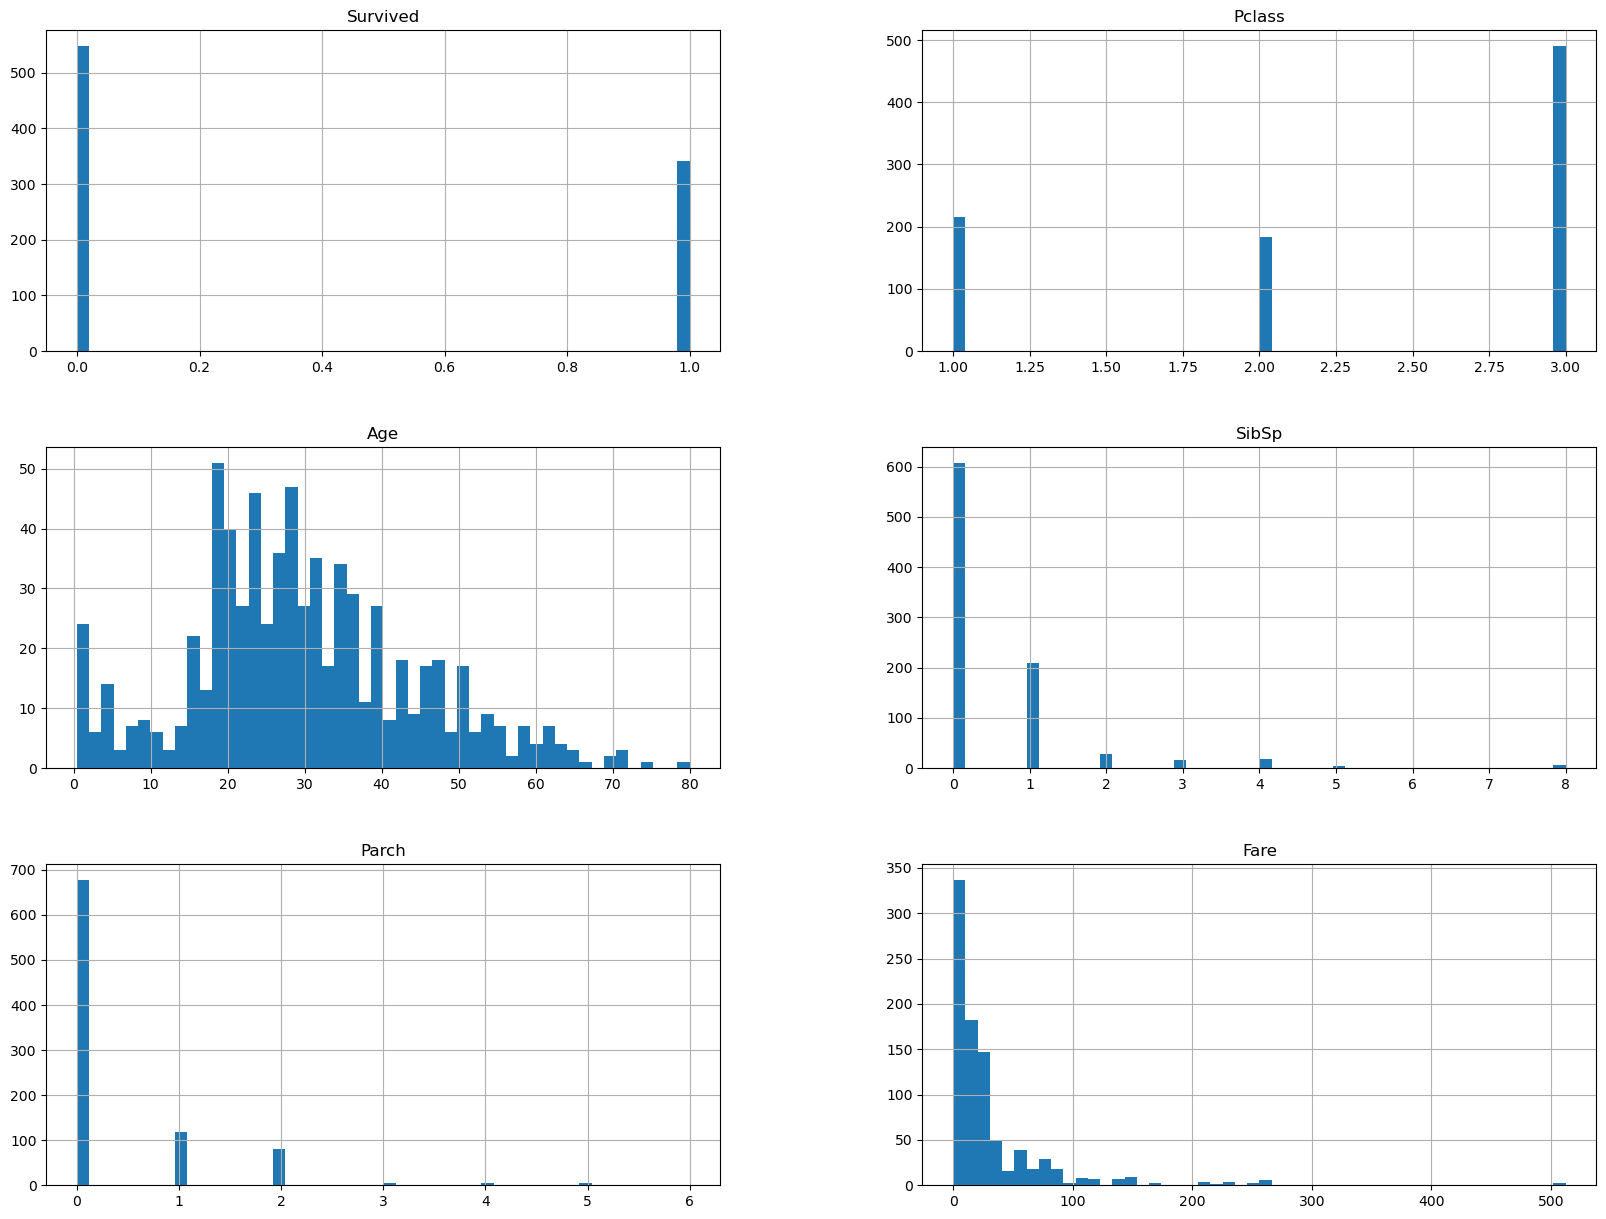

In [7]:
train_data[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].hist(bins=50, figsize=(20,15))
plt.show()

#### Categorial data

In [8]:
# Sex, Ticket, Cabin, Embarked

train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [9]:
train_data['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [10]:
train_data['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [11]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

# Prepare the Data

### Steps:
1. Data cleaning: remove empty values or fill them to some value
2. Transform useful categorial data to the numerical one
3. Engineer new features
4. Normalize features

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [13]:
train_data_labels = train_data["Survived"].copy() # move labels to the seperate list
train_data_cln = train_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket'], axis=1) # remove redundant attributes
train_data_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Cabin     204 non-null    object 
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


### Cabin feature transformation

In [14]:
def transform_cabin_data(data):
    raw_cabin_data = data[["Cabin"]].copy()
    raw_cabin_data["Cabin_Data"] = data["Cabin"].isnull().apply(lambda x: not x)
    raw_cabin_data["Deck"] = raw_cabin_data["Cabin"].str.slice(0,1)
    raw_cabin_data = raw_cabin_data["Deck"].fillna("N")
    return raw_cabin_data

In [15]:
train_data_cln['Cabin'] = transform_cabin_data(train_data_cln)

In [16]:
train_data_cln['Cabin']

0      N
1      C
2      N
3      C
4      N
      ..
886    N
887    B
888    N
889    C
890    N
Name: Cabin, Length: 891, dtype: object

In [17]:
train_data_cln['Cabin'].value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

In [18]:
# also transform test cabin data
test_data['Cabin'] = transform_cabin_data(test_data)
test_data['Cabin']

0      N
1      N
2      N
3      N
4      N
      ..
413    N
414    C
415    N
416    N
417    N
Name: Cabin, Length: 418, dtype: object

### New features

In [19]:
train_data_cln["RelativesOnboard"] = train_data_cln["SibSp"] + train_data_cln["Parch"]
train_data_cln =train_data_cln.drop(['SibSp', 'Parch'], axis=1) # remove redundant attributes

In [20]:
test_data["RelativesOnboard"] = test_data["SibSp"] + test_data["Parch"]
test_data = test_data.drop(['SibSp', 'Parch'], axis=1) # remove redundant attributes

In [21]:
train_data_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Pclass            891 non-null    int64  
 1   Sex               891 non-null    object 
 2   Age               714 non-null    float64
 3   Fare              891 non-null    float64
 4   Cabin             891 non-null    object 
 5   Embarked          889 non-null    object 
 6   RelativesOnboard  891 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 48.9+ KB


### Transformation pipeline

In [22]:
# Fill missed embarked data with the most frequent one
most_frequent = train_data_cln['Embarked'].mode()[0]
train_data_cln['Embarked'].fillna(most_frequent, inplace=True)

In [23]:
train_data_cln['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [24]:
# numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])

# categorial pipeline
cat_pipeline = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), ['Sex']),
    ('one_hot', OneHotEncoder(sparse_output=False), ['Pclass', 'Cabin', 'Embarked'])
])

# full pipeline
numerical_attribs = ['Age', 'RelativesOnboard', 'Fare']
categorial_attribs = ['Pclass', 'Sex', 'Cabin', 'Embarked']


full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numerical_attribs),
    ('cat', cat_pipeline, categorial_attribs)
])

train_data_transformed = full_pipeline.fit_transform(train_data_cln)
train_data_transformed[:2]

array([[-0.5924806 ,  0.05915988, -0.50244517,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.63878901,  0.05915988,  0.78684529,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ]])

In [25]:
train_data_transformed.shape

(891, 19)

In [26]:
train_data_labels.shape

(891,)

In [27]:
test_data_prepared = full_pipeline.transform(test_data)

In [28]:
test_data_prepared.shape

(418, 19)

# Model Training

In [29]:
forest_classifier = RandomForestClassifier()
forest_classifier.fit(train_data_transformed, train_data_labels)

RandomForestClassifier()

In [30]:
#predictions = forest_classifier.predict(test_data_prepared)

#output = pd.DataFrame({'PassengerId': test_data_cleaned.PassengerId, 'Survived': predictions})
#output.to_csv('submission.csv', index=False)

In [31]:
y_predicts = cross_val_predict(forest_classifier, train_data_transformed, train_data_labels, cv=3)

print("Accuracy: ", accuracy_score(train_data_labels, y_predicts))
print("Precision: ", precision_score(train_data_labels, y_predicts))
print("Recall: ", recall_score(train_data_labels, y_predicts))

Accuracy:  0.7968574635241302
Precision:  0.7507788161993769
Recall:  0.7046783625730995


# Grid Search

In [32]:
params_grid = [
    {'n_estimators': [10, 30, 100, 1000], 'max_features': [2, 4, 6, 8, 10]}
]

forest_clf = RandomForestClassifier()

grid_search = GridSearchCV(forest_clf, params_grid, cv=5, scoring='accuracy', return_train_score=True)

grid_search.fit(train_data_transformed, train_data_labels)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 4, 6, 8, 10],
                          'n_estimators': [10, 30, 100, 1000]}],
             return_train_score=True, scoring='accuracy')

In [33]:
print("Best estimator: ", grid_search.best_estimator_)
print("Best params", grid_search.best_params_)
print("Accuracy: " + str(grid_search.best_score_))

Best estimator:  RandomForestClassifier(max_features=8)
Best params {'max_features': 8, 'n_estimators': 100}
Accuracy: 0.8159625886636117


In [34]:
best_model = grid_search.best_estimator_

predictions = best_model.predict(test_data_prepared)

#output = pd.DataFrame({'PassengerId': test_data_cleaned.PassengerId, 'Survived': predictions})
#output.to_csv('submission.csv', index=False)

### K Neighbors Classifier

In [35]:
params_grid = [
    {'n_neighbors': [7, 11, 13, 15], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
]

knn_clf = KNeighborsClassifier()

grid_search_knn = GridSearchCV(knn_clf, params_grid, cv=5, scoring='accuracy', return_train_score=True)

grid_search_knn.fit(train_data_transformed, train_data_labels)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['euclidean', 'manhattan'],
                          'n_neighbors': [7, 11, 13, 15],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='accuracy')

In [36]:
print("Best estimator: ", grid_search_knn.best_estimator_)
print("Best params", grid_search_knn.best_params_)
print("Accuracy: " + str(grid_search_knn.best_score_))

Best estimator:  KNeighborsClassifier(metric='euclidean', n_neighbors=11)
Best params {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Accuracy: 0.8058941686020965


In [37]:
best_model = grid_search_knn.best_estimator_
predictions = best_model.predict(test_data_prepared)

#output = pd.DataFrame({'PassengerId': test_data_cleaned.PassengerId, 'Survived': predictions})
#output.to_csv('submission.csv', index=False)

In [38]:
predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

### SVM

In [39]:
# Create a SVC classifier
clf = SVC()

# Create a grid of hyperparameters to search
param_grid = {'C': np.linspace(0.1, 10.0, 10), 'kernel': ['linear', 'rbf']}

# Create a GridSearchCV object
grid = GridSearchCV(clf, param_grid, cv=10, return_train_score=True)
grid.fit(train_data_transformed, train_data_labels)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([ 0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
                         'kernel': ['linear', 'rbf']},
             return_train_score=True)

In [40]:
print("Best estimator: ", grid.best_estimator_)
print("Best params", grid.best_params_)
print("Accuracy: " + str(grid.best_score_))

Best estimator:  SVC(C=2.3000000000000003)
Best params {'C': 2.3000000000000003, 'kernel': 'rbf'}
Accuracy: 0.8282771535580526


In [41]:
best_model = grid.best_estimator_
predictions = best_model.predict(test_data_prepared)

In [42]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

In [43]:
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
